In [1]:
from tika import parser # pdf scraping

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import sqlite3

In [2]:
def get_year(competition):
    """
    Get year the competition was held
    :param competition: competition data scraped from the pdf [dict]
    :return: competition year [int]
    """

    competition_text = competition['content']
    year = int(re.search('20[0,1][0-9]', competition_text).group())

    return year


def get_jury(competition):
    """
    Get a list of juries at the competition. It is returned as list of tuples containing judge name and his nationality.
    :param competition: competition data scraped from the pdf [dict]
    :return: list of lists (jury_name, nationality) [list]
    """

    jury = []
    competition_text = competition['content']
    upper_boundary = '\n\nA '
    # Line below finds where to the jury list begins and '-2' is to remain the A character for iteration
    upper_trim = competition_text[competition_text.find(upper_boundary)+len(upper_boundary)-2 :]

    # I have to iterate with A-E characters, as in some cases there are unexpected blank lines between particular judges
    for letter in ['A', 'B', 'C', 'D', 'E']:
        upper_trim = upper_trim[upper_trim.find(letter+' '):]
        cut_line = upper_trim.split('\n')[0]
        nationality = cut_line[-3:]
        judge_name = re.sub(',', '', cut_line[2: -4])
        jury.append([judge_name, nationality])

    assert len(jury) == 5, f'Invalid number of judges! Got {len(jury)}'

    return jury


def note_to_float(score):
    '''
    Convert note to float. Some of them contain dots and some contain comas, so change it if needed.
    :param score: score [str]
    :return: score [float]
    '''

    return float(re.sub(',', '.', score))


def get_referenced_notes(score):
    '''
    Get difference between particular note and mean of notes of other judges
    :param score: list of notes [list]
    :return: list of differences [list]
    '''

    return [note - (sum(score)-note)/4 for note in score]


def get_competition_scores(competition):
    '''
    Extract scores from the competition. If jumper took part in both rounds, append his jumps as two separate list elements.
    :param competition: competition data scraped from the pdf [dict]
    :return: list of lists containing [jumper_name, jumper_country, note_A, note_B, note_C, note_D, note_E] [list]
    '''

    competition_text = competition['content']

    # Remove dots after place number, if they appear
    competition_text = re.sub('[.] ', ' ', competition_text)

    # Search for text fragments which match places pattern and split the text
    # The pattern is as follows: two new line characters, one or zero spaces, one or zero digits [1-5], one digit [0-9], a space or a dot
    competition_split = re.split(r'\n\n ?[1-5]?[0-9][. ]', competition_text)

    scores = []

    for place_fragment in competition_split[1:]:

        # Remove blank lines in list elements containing place (sometimes they appear, and sometimes do not) and split fragment into lines
        place_fragment = re.sub('\n\n', '\n', place_fragment).splitlines()
        # Get jumper name with no comas and country
        jumper_name = re.sub(', ', ' ', place_fragment[1])
        jumper_country = place_fragment[3].split()[0]
        # Get first round notes
        jumper_notes = [note_to_float(note) for note in place_fragment[4].split()[3:8]]
        jumper_referenced_notes = get_referenced_notes(jumper_notes)
        # Append first round notes
        scores.append([jumper_name, jumper_country]+jumper_notes+jumper_referenced_notes)

        # Check first character of first element of next line - if it is a digit, that means it also contains notes,
        # which means jumper took part in final round. Append score as new list element
        if len(place_fragment) > 5:
            if place_fragment[5].split()[0][0].isdigit():
                jumper_notes = [note_to_float(note) for note in place_fragment[5].split()[3:8]]
                jumper_referenced_notes = get_referenced_notes(jumper_notes)
                scores.append([jumper_name, jumper_country]+jumper_notes+jumper_referenced_notes)

    return scores

In [3]:
# Create DataFrame to store competition data - year and judges names
competition_data_columns = ['competition_id', 'year', 'referee_A', 'referee_B', 'referee_C', 'referee_D', 'referee_E']
competition_data_df = pd.DataFrame(columns=competition_data_columns)

# Create DataFrame to store all notes
scores_df_columns = ['competition_id', 'jumper_name', 'jumper_country', 'note_A', 'note_B', 'note_C', 'note_D', 'note_E']
scores_df = pd.DataFrame(columns=scores_df_columns)

# Create DataFrame to store jury countries
jury_data_columns = ['judge_name', 'judge_nationality']
jury_data_df = pd.DataFrame(columns=jury_data_columns)

# Fill DataFrame with competitions scores
data_path = 'data/'
competition_scores_columns = ['jumper_name', 'jumper_country', 'note_A', 'note_B', 'note_C', 'note_D', 'note_E', 'referenced_A', 'referenced_B', 'referenced_C', 'referenced_D', 'referenced_E']

for file_name in os.listdir(data_path):

    # Competition scores
    file_path = data_path + file_name
    # print(f'Scanning {file_path}')
    pdf = parser.from_file(file_path)
    competition_scores_list = get_competition_scores(pdf)
    competition_scores_df = pd.DataFrame(competition_scores_list, columns=competition_scores_columns)
    competition_scores_df['competition_id'] = file_name
    scores_df = pd.concat([scores_df, competition_scores_df])
    # print(f'Jumps performed: {len(competition_scores_list)}')

    # Competition data
    jury_names = [x[0] for x in get_jury(pdf)]
    competition_data_df = pd.concat([
        competition_data_df,
        pd.DataFrame([[file_name, get_year(pdf)] + jury_names], columns=competition_data_columns)
    ])

    # Jury data
    for jury in get_jury(pdf):
        if jury[0] not in jury_data_df['judge_name'].to_numpy():
            jury_data_df = pd.concat([
                jury_data_df,
                pd.DataFrame([jury], columns=jury_data_columns)
            ])

2023-02-19 13:28:42,779 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


# Let's check the data

## Competition data
As we can see, there is no null values, seems like the referees and competition years have been filled nice

In [4]:
competition_data_df.head()

,competition_id,year,referee_A,referee_B,referee_C,referee_D,referee_E
0,2005JP3007RL.pdf,2005,Schnetzer Manfred,Langer Andreas,Bakken Knut A.,Braz Vladimir,Nordin Hans
0,2005JP3008RL.pdf,2005,Nordin Hans,Bras Vladimir,Hess Bernd,Bakken Knut A.,Wolf Stefan
0,2005JP3012RL.pdf,2005,Justin Toni,Kaekilehto Juhani,Krab Gerhard,Minemura Yutaka,Aschenbach Dietmar
0,2005JP3013RL.pdf,2005,Krab Gerhard,Aschenbach Dietmar,Justin Toni,Minemura Yutaka,Kaekilehto Juhani
0,2005JP3019RL.pdf,2004,Hoehnl Rudolf,Stahlhut Erik,Livland Nils,Pichler Johann,Bester Janez


In [5]:
competition_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 0
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   competition_id  88 non-null     object
 1   year            88 non-null     object
 2   referee_A       88 non-null     object
 3   referee_B       88 non-null     object
 4   referee_C       88 non-null     object
 5   referee_D       88 non-null     object
 6   referee_E       88 non-null     object
dtypes: object(7)
memory usage: 5.5+ KB


## Jury data
Also seems nice

In [6]:
jury_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 0
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   judge_name         138 non-null    object
 1   judge_nationality  138 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [7]:
jury_data_df.head()

,judge_name,judge_nationality
0,Schnetzer Manfred,AUT
0,Langer Andreas,GER
0,Bakken Knut A.,NOR
0,Braz Vladimir,SLO
0,Nordin Hans,SWE


## Competition scores
Let's see it and discuss it later:

In [8]:
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6987 entries, 0 to 79
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   competition_id  6987 non-null   object 
 1   jumper_name     6987 non-null   object 
 2   jumper_country  6987 non-null   object 
 3   note_A          6984 non-null   float64
 4   note_B          6984 non-null   float64
 5   note_C          6984 non-null   float64
 6   note_D          6984 non-null   float64
 7   note_E          6984 non-null   float64
 8   referenced_A    6984 non-null   float64
 9   referenced_B    6984 non-null   float64
 10  referenced_C    6984 non-null   float64
 11  referenced_D    6984 non-null   float64
 12  referenced_E    6984 non-null   float64
dtypes: float64(10), object(3)
memory usage: 764.2+ KB


In [9]:
scores_df.describe()

,note_A,note_B,note_C,note_D,note_E,referenced_A,referenced_B,referenced_C,referenced_D,referenced_E
count,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000
mean,17.750215,17.766180,17.725014,17.732030,17.775988,0.000412,0.020368,-0.031089,-0.022319,0.032628
std,1.146476,1.141918,1.151998,1.169309,1.592028,0.492640,0.477977,0.475486,0.484181,1.202295
min,9.500000,8.500000,8.000000,8.000000,8.000000,-9.250000,-9.250000,-9.000000,-8.875000,-2.250000
25%,17.500000,17.500000,17.000000,17.000000,17.500000,-0.250000,-0.250000,-0.250000,-0.250000,-0.250000
50%,18.000000,18.000000,18.000000,18.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.500000,18.500000,18.500000,18.500000,18.500000,0.250000,0.250000,0.250000,0.250000,0.250000
max,20.000000,20.000000,20.000000,20.000000,53.500000,3.375000,3.375000,1.875000,2.500000,35.750000


In [10]:
scores_df.head()

,competition_id,jumper_name,jumper_country,note_A,note_B,note_C,note_D,note_E,referenced_A,referenced_B,referenced_C,referenced_D,referenced_E
0,2005JP3007RL.pdf,Ahonen Janne,FIN,19.5,18.5,19.0,19.0,19.0,0.625,-0.625,0.000,0.000,0.000
1,2005JP3007RL.pdf,Ahonen Janne,FIN,18.0,17.0,16.5,16.5,18.0,1.000,-0.250,-0.875,-0.875,1.000
2,2005JP3007RL.pdf,Malysz Adam,POL,19.0,19.0,18.0,18.5,18.5,0.500,0.500,-0.750,-0.125,-0.125
3,2005JP3007RL.pdf,Malysz Adam,POL,18.5,18.5,18.0,18.0,18.0,0.375,0.375,-0.250,-0.250,-0.250
4,2005JP3007RL.pdf,Janda Jakub,CZE,19.0,19.0,19.0,19.0,18.5,0.125,0.125,0.125,0.125,-0.500


As we see above, we got 6987 entries, in which 6984 non-null. That means we got three null entries that will be dropped. What's more, we can see a very generous note from judge E - 53.5, whilst in ski jumping maximum we can get is 20. The judges can give notes that are full or full and half points.

# Data cleaning

We will drop null entries and remove values that are above 20 or that are not x.0 or x.5 values.

In [11]:
scores_df_clean = scores_df.dropna()

for note_index in ['A', 'B', 'C', 'D', 'E']:
    column = f'note_{note_index}'
    scores_df_clean = scores_df_clean[
        (scores_df_clean[column]<=20) & (scores_df_clean[column]%0.5==0)
]

Check clean DataFrame

In [12]:
scores_df_clean.describe()

,note_A,note_B,note_C,note_D,note_E,referenced_A,referenced_B,referenced_C,referenced_D,referenced_E
count,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000
mean,17.751433,17.767345,17.725917,17.732798,17.738389,0.010321,0.030211,-0.021574,-0.012973,-0.005985
std,1.145944,1.141489,1.151652,1.169593,1.137536,0.396322,0.379340,0.383509,0.396046,0.375815
min,9.500000,8.500000,8.000000,8.000000,8.000000,-2.625000,-3.125000,-5.500000,-6.375000,-2.250000
25%,17.500000,17.500000,17.000000,17.000000,17.500000,-0.250000,-0.250000,-0.250000,-0.250000,-0.250000
50%,18.000000,18.000000,18.000000,18.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.500000,18.500000,18.500000,18.500000,18.500000,0.250000,0.250000,0.250000,0.250000,0.250000
max,20.000000,20.000000,20.000000,20.000000,20.000000,3.375000,3.375000,1.875000,2.500000,3.250000


# Creating a database

As this is an educational project we will create a database and insert our data into tables to get more skills in SQL. So some tasks will be performed directly using Pandas and some using SQL

## Create tables

In [13]:
db = sqlite3.connect('ski_jumping_database')
cursor = db.cursor()
cursor.execute('CREATE TABLE IF NOT EXISTS competitions (competition_id, year, referee_A, referee_B, referee_C, referee_D, referee_E)')
cursor.execute('CREATE TABLE IF NOT EXISTS jury (judge_name, judge_nationality)')
cursor.execute('CREATE TABLE IF NOT EXISTS notes (competition_id, jumper_name, jumper_country, note_A, note_B, note_C, note_D, note_E, referenced_A, referenced_B, referenced_C, referenced_D, referenced_E)')
db.commit()

## Insert data into tables

In [14]:
competition_data_df.to_sql('competitions', db, if_exists='replace', index=False)
jury_data_df.to_sql('jury', db, if_exists='replace', index=False)
scores_df_clean.to_sql('notes', db, if_exists='replace', index=False)

6976

Let's check if it works

In [15]:
cursor.execute("SELECT * "
               "FROM jury "
               "WHERE judge_nationality = 'POL';")
for row in cursor:
    print(row)

('Dlugopolski Kazimierz', 'POL')
('Szostak Tadeusz', 'POL')
('Siderek Marek', 'POL')
('Tucznio Marek', 'POL')
('Gunka Ryszard', 'POL')
('Nadarkiewicz Edward', 'POL')
('Pilch Jerzy', 'POL')
('Przybyta Edward', 'POL')


Seems ok

# Exploratory data analysis

### Competitors and judges
At the beginning let's check how many judges and competitors of each nationality took part in our competitions. For training purposes we will get one value using SQL and one from Pandas.

In [16]:
# Create a DataFrame containing distinct values of jumpers and countries
jumpers_df = scores_df_clean.drop_duplicates(subset=['jumper_name', 'jumper_country'])[['jumper_name', 'jumper_country']]
print(jumpers_df['jumper_country'].unique())

['FIN' 'POL' 'CZE' 'AUT' 'GER' 'JPN' 'NOR' 'SLO' 'FRA' 'SUI' 'RUS' 'BLR'
 'USA' 'SVK' 'EST' 'SWE' 'Puijon' 'Orkdal' 'SV' 'Lahden' 'Dukla' 'WSV-DJK'
 'KS' 'SC' 'IL' 'Byaasen' 'Hurdal' 'RG' 'Ilirija' 'Tromsoe' 'SK'
 'Jyvaeskylaen' 'Team' 'Hosle' 'WSC' 'Tsuchiya' 'Magadan' 'WSV' 'Sdushor'
 'CSK' 'Douanes' 'Triglav' 'Shimokawa' 'WKS' 'FIT' 'Trondheim' 'Mizuno'
 'Nihon' 'Rollag' 'Snow' 'Holmens' 'Ounasvaaran' 'RCHWCM' 'KAZ' 'CHN'
 'KOR' 'LKS' 'G.S' 'Ready' 'Steinkjer' 'Tschimbulak' 'Eins' 'TS'
 'Steamboat' 'Vikersund' 'Ljubno' 'ITA' 'NED' 'BUL' 'KGZ']


We can see that on some cases there is jumper's team name instead of country ID. We will drop them.

In [17]:
jumpers_df = jumpers_df.loc[jumpers_df['jumper_country'].str.len()==3]
# Print values left
print(jumpers_df['jumper_country'].unique())

['FIN' 'POL' 'CZE' 'AUT' 'GER' 'JPN' 'NOR' 'SLO' 'FRA' 'SUI' 'RUS' 'BLR'
 'USA' 'SVK' 'EST' 'SWE' 'WSC' 'WSV' 'CSK' 'WKS' 'FIT' 'KAZ' 'CHN' 'KOR'
 'LKS' 'G.S' 'ITA' 'NED' 'BUL' 'KGZ']


In [18]:
# Drop remaining rows that are not country indexes
bad_index = ['WSC', 'WSV', 'CSK', 'WKS', 'FIT', 'LKS', 'G.S', 'KGZ']
jumpers_df = jumpers_df.loc[jumpers_df['jumper_country'].apply(lambda x: x not in bad_index)]
jumpers_df.head()

,jumper_name,jumper_country
0,Ahonen Janne,FIN
2,Malysz Adam,POL
4,Janda Jakub,CZE
6,Morgenstern Thomas,AUT
8,Hoellwarth Martin,AUT


In [33]:
# Plots styling
sns.set_theme(
    style='whitegrid',
)
blue_palette = sns.color_palette('Blues', 50)

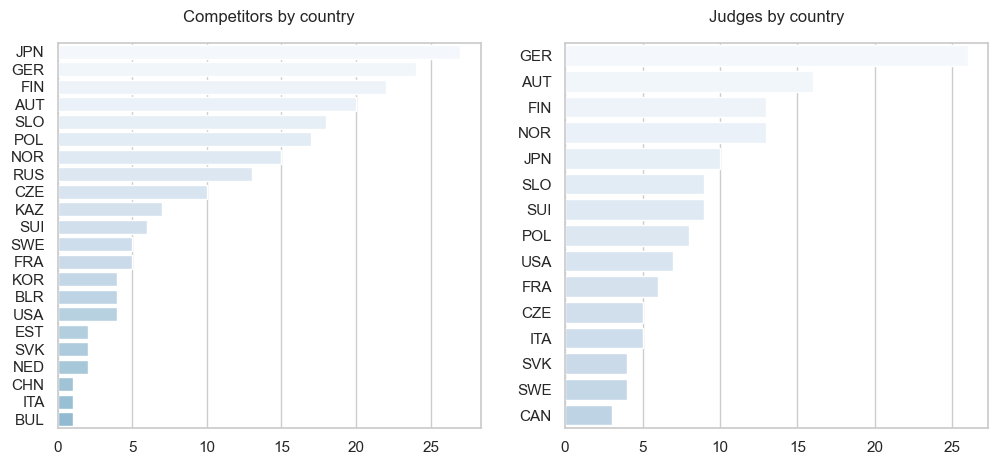

In [34]:
# Create figure and plots
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Competitors
jumpers_df_countries = jumpers_df['jumper_country'].value_counts()
sns.barplot(
    y=jumpers_df_countries.index,
    x=jumpers_df_countries.values,
    ax=ax0,
    palette=blue_palette
)
ax0.set_title('Competitors by country', pad=15)

# Judges
jury_countries_list = []
cursor.execute("SELECT judge_nationality, count(*) "
               "FROM jury "
               "GROUP BY judge_nationality")
for row in cursor:
    jury_countries_list.append([row[0], row[1]])
jury_countries_df = pd.DataFrame(data=jury_countries_list, columns=['country_id', 'count']).sort_values(by='count', ascending=False)
ax1 = sns.barplot(
    data=jury_countries_df,
    x='count',
    y='country_id',
    ax=ax1,
    palette=blue_palette
)
ax1.set_title('Judges by country', pad=15)
ax1.set(xlabel=None, ylabel=None)

plt.show()

It can be seen that the most distinct jumpers were from Japan. Let's have a look how many particular jumps were performed by jumpers from every country. We must remember that for some jumpers there is still team name instead of his country id. Let's not look at those entries.

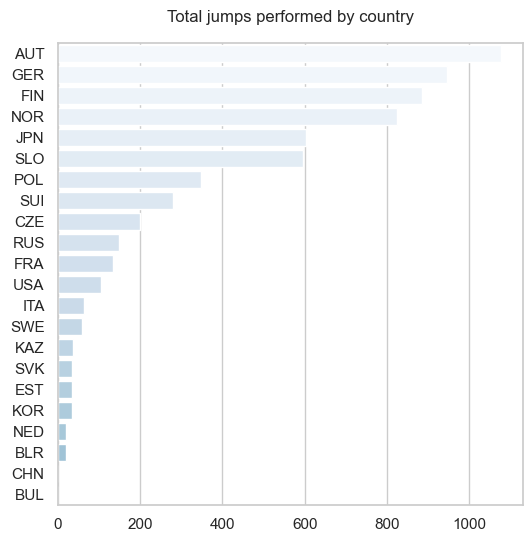

In [35]:
# Prepare data
valid_countries = jumpers_df['jumper_country'].values
jumps_df_clean = scores_df_clean[scores_df_clean['jumper_country'].isin(valid_countries)]
jumps_df_countries_count = jumps_df_clean['jumper_country'].value_counts()

fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(
    # data=jumps_df_clean,
    x=jumps_df_countries_count.values,
    y=jumps_df_countries_count.index,
    ax=ax,
    palette=blue_palette
)
ax.set_title('Total jumps performed by country', pad=15)

plt.show()

As can be seen, most jumps were done by Austrian jumpers.

### Notes
Let's see what is overall notes distribution. To check it let's consider all notes given in those competititons. I will convert the data into a Series object, so that we can easily plot them and get statistics parameters.

In [21]:
# Prepare a 1-D series object to store all notes in one column
notes_1d = scores_df_clean.melt(value_vars=['note_A', 'note_B', 'note_C', 'note_D', 'note_E'])['value']
notes_1d.head()

0    19.5
1    18.0
2    19.0
3    18.5
4    19.0
Name: value, dtype: float64

In [22]:
# Check distribution parameters
notes_1d.describe()

count    34880.000000
mean        17.743177
std          1.149325
min          8.000000
25%         17.500000
50%         18.000000
75%         18.500000
max         20.000000
Name: value, dtype: float64

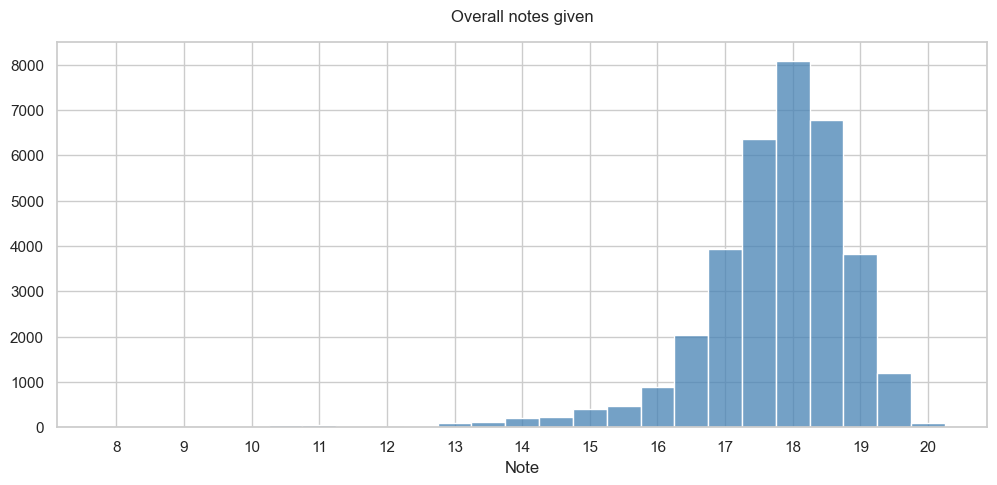

In [23]:
# Create list of bin edges
min_note = min(notes_1d)
max_note = max(notes_1d)
step_note = 0.5
bins_edges = np.arange(
    min_note - step_note/2,
    max_note + step_note,
    step_note
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(
    data=notes_1d,
    bins=bins_edges,
    ax=ax,
    color='steelblue'
)
ax.set_title('Overall notes given', pad=15)
ax.set_xticks(np.arange(8, 21))
ax.set_xlabel('Note')
ax.set_ylabel('')

plt.show()

As we can see, with this big amount of notes (almost 35 thousands) their distribution is close to normal with average of 17,743 and standard deviation 1,149.

### Notes by country
Next we will check what notes got jumpers by their countries. Who are the prettiest fliers?

In [24]:
# Prepare a DataFrame containing jumper's country and note (one note per row)
country_notes_df = scores_df_clean.melt(id_vars='jumper_country', value_vars=['note_A', 'note_B', 'note_C', 'note_D', 'note_E'])[['jumper_country', 'value']]
# Delete entries with invalid country
country_notes_df = country_notes_df[country_notes_df['jumper_country'].isin(valid_countries)]
country_notes_df.head()

,jumper_country,value
0,FIN,19.5
1,FIN,18.0
2,POL,19.0
3,POL,18.5
4,CZE,19.0


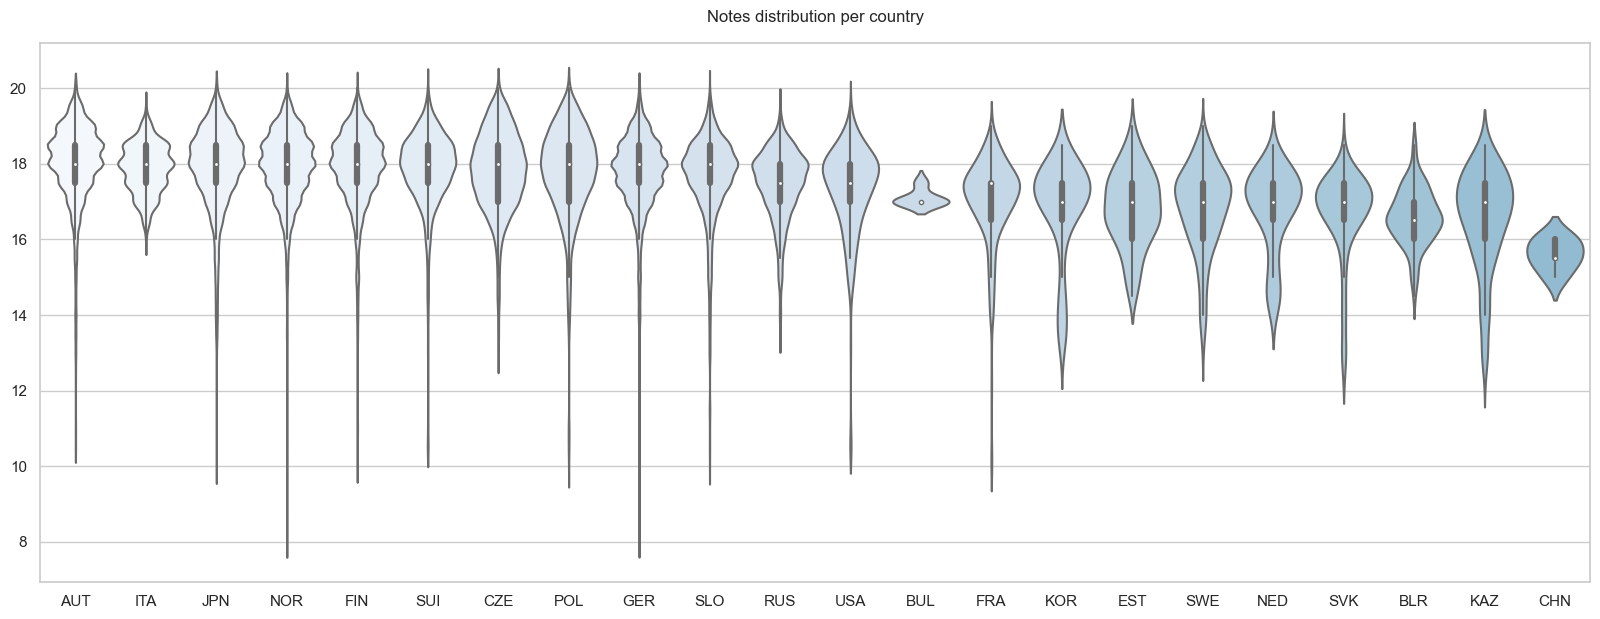

In [36]:
# Calculate average note for each country to sort them
best_average_note_df = country_notes_df.groupby(['jumper_country']).mean().sort_values(by='value', ascending=False)
best_average_note_list = list(best_average_note_df.index)

fig,ax = plt.subplots(figsize=(20, 7))
sns.violinplot(
    data=country_notes_df,
    x='jumper_country',
    y='value',
    ax=ax,
    palette=blue_palette,
    scale='width',
    order=best_average_note_list
)
ax.set_title('Notes distribution per country', pad=15)
ax.set_ylabel('')
ax.set_xlabel('')

plt.show()

At the plot above we can see distributions of notes amongst jumpers from particular countries. Countries are sorted by their average note - from the highest on the left to the lowest on the right. The shapes of each "violin" represents distribution of notes for each country. We can see that some countries had rather dispersed notes - like Estonia or Czech Republic, and some focused, that usually oscillated around one value - like Slovenia, Russia or USA who got a lot of 18.0 notes.

### Referenced notes
Now we will focus on notes of particular judges in reference to notes of other judges. We will try to answer questions, whether judges favored competitors of their own country and if some judges discriminated other nationalities? <br />
To achieve it we must join some tables to extract nationality of each judge, for each jump. We will get this data from SQL database and save it to a new DataFrame that will make it easier to manage it.

In [37]:
# Create SQL query to get relevant data
judge_letter = 'A'
sql_query = (f"SELECT n.jumper_name, n.jumper_country, n.note_{judge_letter}, "
             f"n.referenced_{judge_letter}, c.referee_{judge_letter}, j.judge_nationality "
             "FROM notes as n "
             "inner join competitions as c "
             "on n.competition_id=c.competition_id "
             "inner join jury as j "
             f"on c.referee_{judge_letter}=j.judge_name "
             )

# Let's see its outcome
cursor.execute(sql_query)
for row in cursor.fetchmany(5):
    print(list(row))

['Ahonen Janne', 'FIN', 19.5, 0.625, 'Schnetzer Manfred', 'AUT']
['Ahonen Janne', 'FIN', 18.0, 1.0, 'Schnetzer Manfred', 'AUT']
['Malysz Adam', 'POL', 19.0, 0.5, 'Schnetzer Manfred', 'AUT']
['Malysz Adam', 'POL', 18.5, 0.375, 'Schnetzer Manfred', 'AUT']
['Janda Jakub', 'CZE', 19.0, 0.125, 'Schnetzer Manfred', 'AUT']


In [117]:
# Get data to fill the DataFrame
country_vs_country_list = []
for judge_letter in ['A', 'B', 'C', 'D', 'E']:
    cursor.execute(sql_query)
    for row in cursor:
        country_vs_country_list.append(list(row))

# Create a DataFrame to store data
country_vs_country_df_columns = ['jumper_name', 'jumper_country', 'note', 'referenced_note', 'judge_name', 'judge_country']
country_vs_country_notes_names_df = pd.DataFrame(country_vs_country_list, columns=country_vs_country_df_columns)
country_vs_country_notes_names_df.head()

,jumper_name,jumper_country,note,referenced_note,judge_name,judge_country
0,Ahonen Janne,FIN,19.5,0.625,Schnetzer Manfred,AUT
1,Ahonen Janne,FIN,18.0,1.000,Schnetzer Manfred,AUT
2,Malysz Adam,POL,19.0,0.500,Schnetzer Manfred,AUT
3,Malysz Adam,POL,18.5,0.375,Schnetzer Manfred,AUT
4,Janda Jakub,CZE,19.0,0.125,Schnetzer Manfred,AUT


In [63]:
# Find and filter only notes where judge was from the same country as jumper
own_country_notes_names_df = country_vs_country_notes_names_df[country_vs_country_notes_names_df['jumper_country'] == country_vs_country_notes_names_df['judge_country']]
own_country_notes_names_df.head()

,jumper_name,jumper_country,note,referenced_note,judge_name,judge_country
6,Morgenstern Thomas,AUT,17.5,0.000,Schnetzer Manfred,AUT
7,Morgenstern Thomas,AUT,19.5,0.750,Schnetzer Manfred,AUT
8,Hoellwarth Martin,AUT,18.0,-0.250,Schnetzer Manfred,AUT
9,Hoellwarth Martin,AUT,18.0,0.125,Schnetzer Manfred,AUT
10,Widhoelzl Andreas,AUT,17.5,-0.375,Schnetzer Manfred,AUT


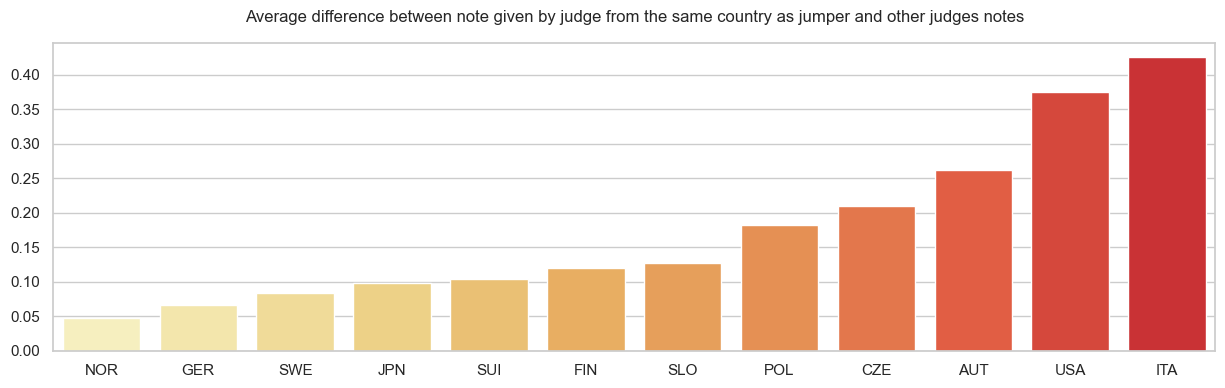

In [84]:
# Create palette of shame
shame_palette = sns.color_palette('YlOrRd', 15)

# Take only relevant columns and calculate average referenced note
own_country_notes_df = own_country_notes_names_df[['jumper_country', 'referenced_note']]
own_country_avg_notes_df = own_country_notes_df.groupby(['jumper_country']).mean().sort_values(by='referenced_note', ascending=False)

# Plot it
fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=own_country_avg_notes_df,
    x=own_country_avg_notes_df.index,
    y='referenced_note',
    ax=ax,
    palette=shame_palette,
    order=own_country_avg_notes_df.index[::-1]
)
ax.set_title('Average difference between note given by judge from the same country as jumper and other judges notes', pad=15)
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

I think I shouldn't have been THAT surprised, but guys - all, literally all judges favored jumpers from their country. What we can conclude from this chart is that there were some judges who did it really vividly, like guys from Italy and USA and those, whose notes hardly differed from the average given by the rest of the crew - like Norwegians or Germans.<br />
Next we will have at how jumpers from each country were judged by referees from each country.

In [106]:
# Create DataFrame to store needed data - we don't need names here
country_vs_country_notes_df = country_vs_country_notes_names_df[['jumper_country', 'referenced_note', 'judge_country']]
# Limit the DataFrame to valid jumper countries
country_vs_country_notes_df = country_vs_country_notes_df[country_vs_country_notes_df['jumper_country'].isin(valid_countries)]
country_vs_country_notes_df.head()

,jumper_country,referenced_note,judge_country
0,FIN,0.625,AUT
1,FIN,1.000,AUT
2,POL,0.500,AUT
3,POL,0.375,AUT
4,CZE,0.125,AUT


In [99]:
country_vs_country_notes_df = country_vs_country_notes_names_df[['jumper_country', 'referenced_note', 'judge_country']]
country_vs_country_notes_df = country_vs_country_notes_df[country_vs_country_notes_df['jumper_country']=='CHN']
country_vs_country_notes_df

,jumper_country,referenced_note,judge_country
775,CHN,0.5,AUT
7751,CHN,0.5,AUT
14727,CHN,0.5,AUT
21703,CHN,0.5,AUT
28679,CHN,0.5,AUT


In [114]:
# Calculate average referenced notes between countries
country_vs_country_avg_notes_df = country_vs_country_notes_df.groupby(['jumper_country', 'judge_country']).mean()
country_vs_country_avg_notes_df

referenced_note
jumper_country judge_country                 
AUT            AUT                   0.262277
               CZE                  -0.043981
               FIN                   0.103495
               GER                  -0.008929
               ITA                   0.032143
...                                       ...
USA            SLO                  -0.034091
               SUI                   0.125000
               SVK                  -0.125000
               SWE                  -0.046875
               USA                   0.375000

[238 rows x 1 columns]